In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import probplot

In [34]:
df = pd.read_csv('transformer_data.csv')
df

,time,Y,Ta,S,I
0,1,23.496733,7.083333,0.0,15.899541
1,2,22.720333,7.116667,0.0,15.861768
2,3,22.052700,7.216667,0.0,16.121469
3,4,21.538050,7.250000,0.0,15.447628
4,5,20.995033,7.316667,0.0,16.258319
...,...,...,...,...,...
163,164,31.510183,14.350000,157.5,16.000643
164,165,30.037760,12.166667,29.0,16.005937
165,166,28.530450,10.283333,0.0,16.427983
166,167,27.118660,8.700000,0.0,16.370292


### Task 2.1

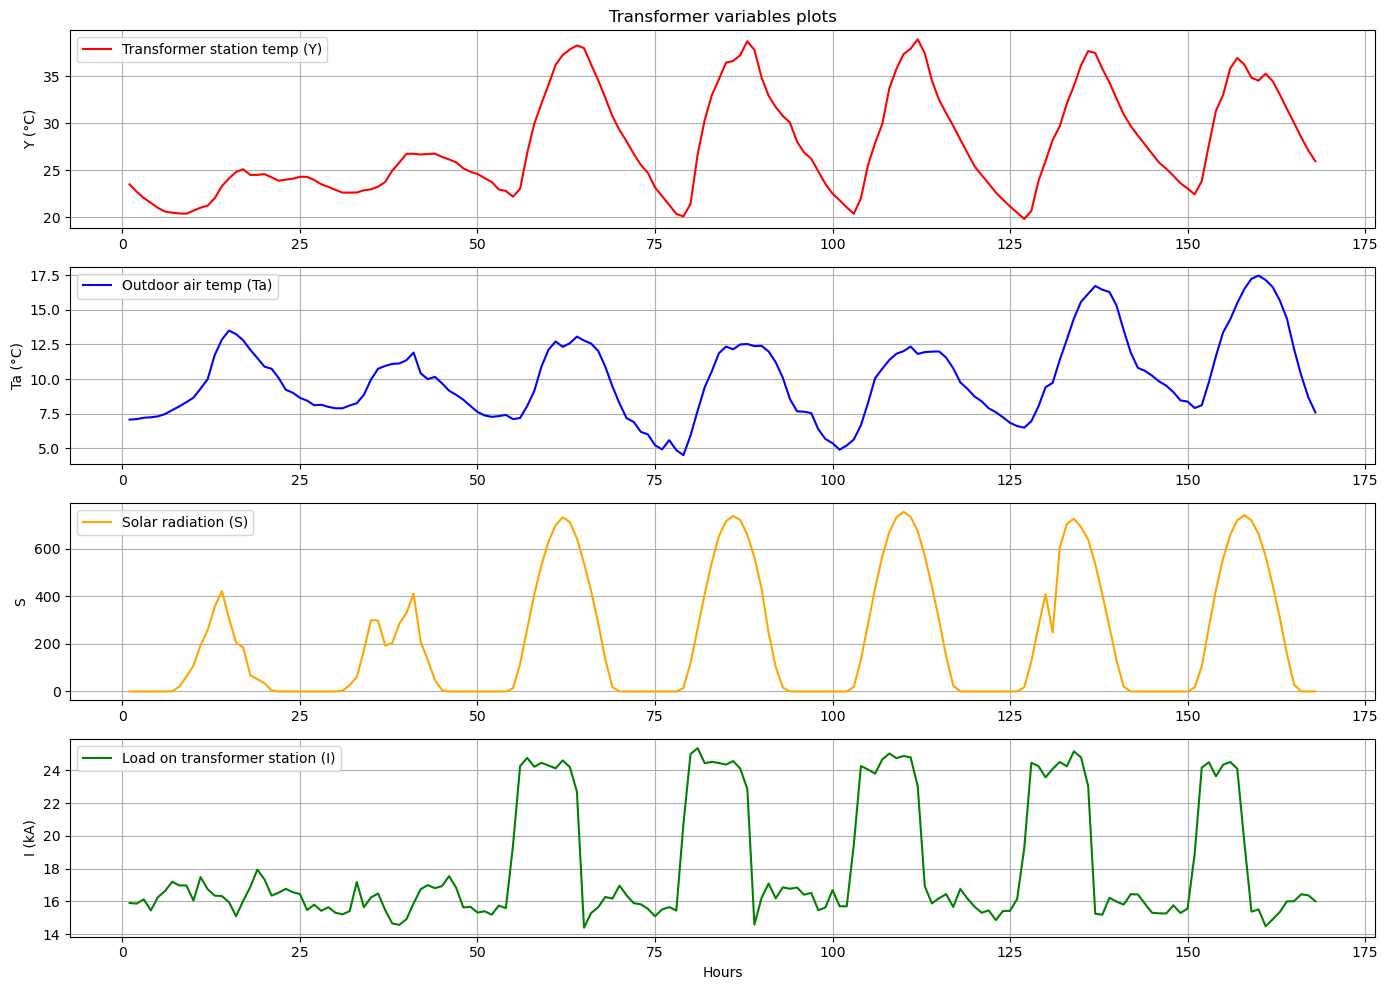

In [ ]:
plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(df['time'], df['Y'], label='Transformer station temp (Y)', color='red')
plt.ylabel('Y (°C)')
plt.title('Transformer variables plots')
plt.grid()
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(df['time'], df['Ta'], label='Outdoor air temp (Ta)', color='blue')
plt.ylabel('Ta (°C)')
plt.grid()
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(df['time'], df['S'], label='Solar radiation (S)', color='orange')
plt.ylabel('S')
plt.grid()
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(df['time'], df['I'], label='Load on transformer station (I)', color='green')
plt.ylabel('I (kA)')
plt.xlabel('Hours')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


### Task 2.2

In [51]:
# Kalman filter log-likelihood function for 1-dimensional model
def kf_logLik_dt_1d(par, Y, U):
    A = np.array([[par[0]]])  # scalar A
    B = np.array(par[1:4]).reshape((1, 3))  # B: 1x3 input matrix
    Q = np.array([[np.exp(par[4]) ** 2]])  # Q: 1x1, system noise covariance
    C = np.array([[par[5]]])  # C: 1x1 observation matrix
    R = np.array([[np.exp(par[6]) ** 2]])  # R: 1x1 observation noise covariance
    X0 = np.array([[20.0]])  # Initial state
    P0 = np.eye(1) * 20

    Tn = Y.shape[0]
    logLik = 0.0
    x_est = X0
    P_est = P0

    for t in range(Tn):
        u_t = U[t].reshape(-1, 1)
        x_pred = A @ x_est + B @ u_t
        P_pred = A @ P_est @ A.T + Q
        y_pred = C @ x_pred
        S_t = C @ P_pred @ C.T + R
        innov = Y[t] - y_pred
        logLik -= 0.5 * (
            np.log(np.linalg.det(S_t)) + innov.T @ np.linalg.inv(S_t) @ innov + np.log(2 * np.pi)
        )
        K_t = P_pred @ C.T @ np.linalg.inv(S_t)
        x_est = x_pred + K_t @ innov
        P_est = (np.eye(1) - K_t @ C) @ P_pred

    return float(logLik)

# Estimation function for 1-dimensional model
def estimate_dt_1d(start_par, Y, U, lower_bounds=None, upper_bounds=None):
    def neg_logLik(par):
        return -kf_logLik_dt_1d(par, Y, U)

    bounds = list(zip(lower_bounds, upper_bounds)) if lower_bounds and upper_bounds else None

    result = minimize(
        fun=neg_logLik,
        x0=start_par,
        method='L-BFGS-B',
        bounds=bounds,
        options={'maxiter': 1000, 'disp': True}
    )

    return result


In [53]:
Y = df[['Y']].values
U = df[['Ta', 'S', 'I']].values

# start parameters and bounds
start_par = np.random.uniform(-1, 1, size=7)
start_par[4:] = np.log(np.abs(start_par[4:]) + 1e-2)

lower_bounds = [-1] * 4 + [-10, -1, -10]  # A, B1-B3, log(σ₁), C, log(σ₂)
upper_bounds = [1] * 4 + [2, 1, 2]

# estimate parameters
result = estimate_dt_1d(start_par, Y, U, lower_bounds, upper_bounds)
result.x, result.fun

C:\Users\Zosia\AppData\Local\Temp\ipykernel_23636\1514722945.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(logLik)


(array([ 8.01029657e-01,  1.01905161e-01,  2.87299661e-03,  2.13448608e-01,
        -4.39284594e-01,  1.00000000e+00, -1.00000000e+01]),
 166.2414231225557)

In [54]:
estimated_params = result.x

In [58]:
# Simulate the 1-dimensional Kalman filter to get residuals
def simulate_kf(par, Y, U):
    A = np.array([[par[0]]])  # scalar A
    B = np.array(par[1:4]).reshape((1, 3))  # B: 1x3 input matrix
    Q = np.array([[np.exp(par[4]) ** 2]])  # Q: 1x1 system noise
    C = np.array([[par[5]]])  # C: 1x1 observation matrix
    R = np.array([[np.exp(par[6]) ** 2]])  # R: 1x1 observation noise
    X0 = np.array([[20.0]])  # Initial state
    P0 = np.eye(1) * 20

    Tn = Y.shape[0]
    x_est = X0
    P_est = P0
    residuals = []

    for t in range(Tn):
        u_t = U[t].reshape(-1, 1)
        x_pred = A @ x_est + B @ u_t
        P_pred = A @ P_est @ A.T + Q
        y_pred = C @ x_pred
        innov = Y[t] - y_pred
        residuals.append(float(innov))
        S_t = C @ P_pred @ C.T + R
        K_t = P_pred @ C.T @ np.linalg.inv(S_t)
        x_est = x_pred + K_t @ innov
        P_est = (np.eye(1) - K_t @ C) @ P_pred

    return np.array(residuals)


C:\Users\Zosia\AppData\Local\Temp\ipykernel_23636\2742212863.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  residuals.append(float(innov))


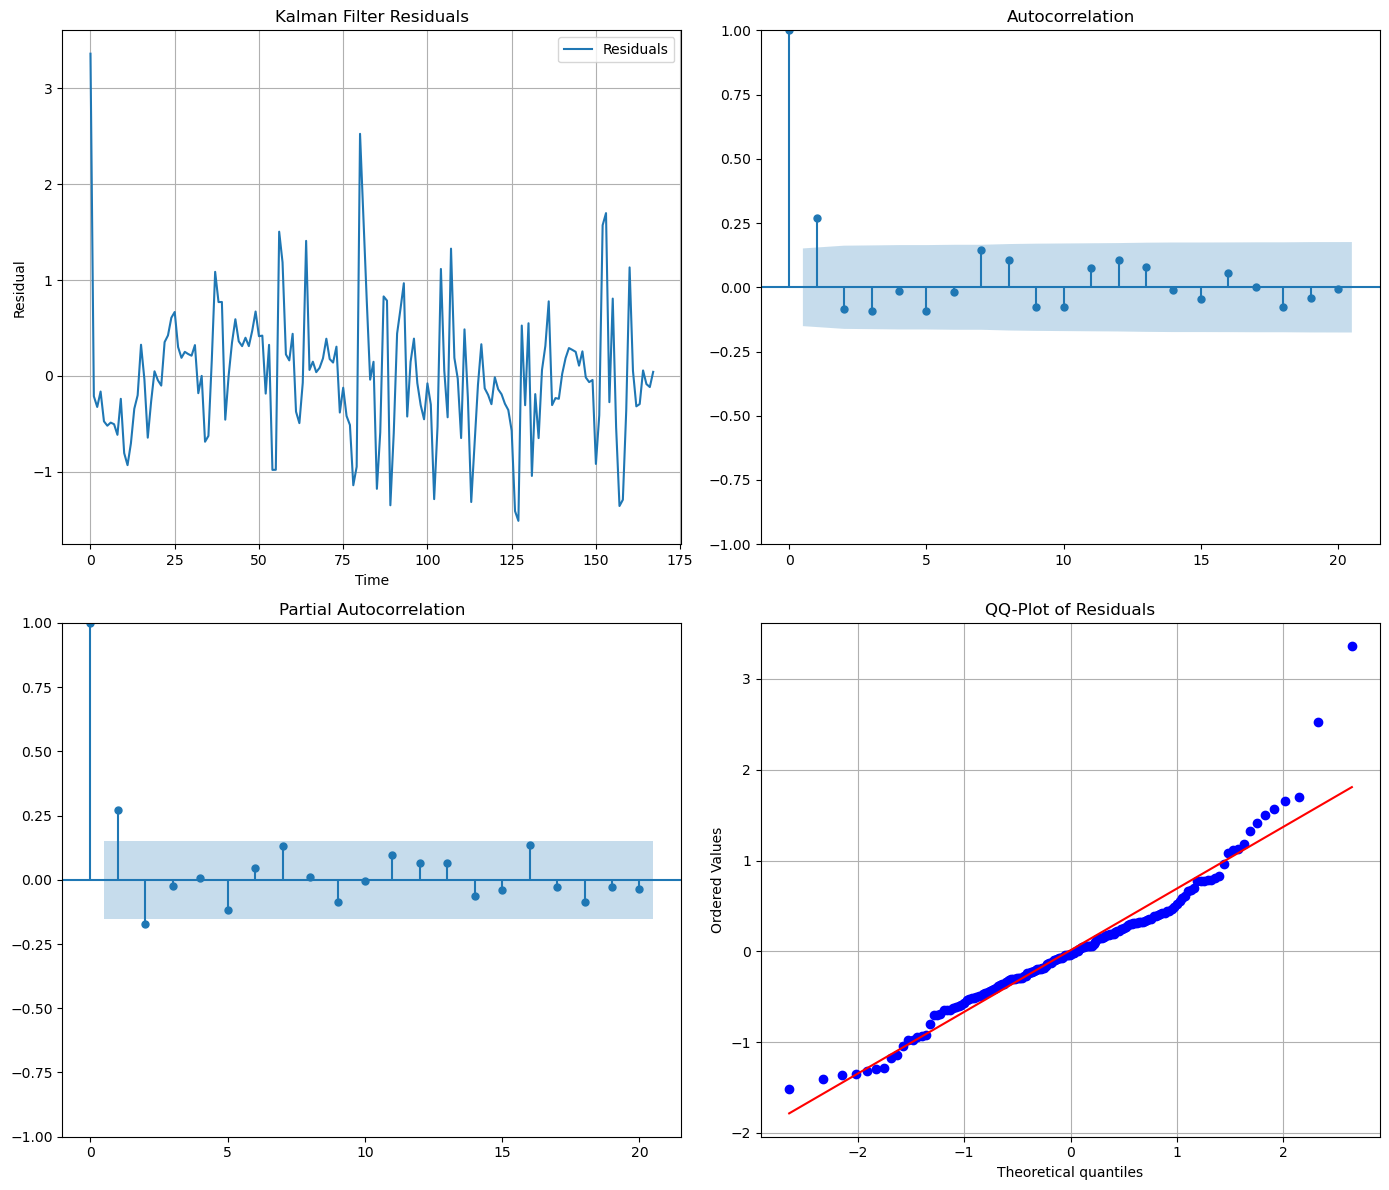

C:\Users\Zosia\AppData\Local\Temp\ipykernel_23636\1514722945.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(logLik)


(346.4828462451114, np.float64(368.3505941009342))

In [59]:
residuals = simulate_kf(estimated_params, Y, U)

# Create a single figure with subplots for residuals, ACF, PACF, and QQ plot
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Residuals plot
axes[0, 0].plot(residuals, label='Residuals')
axes[0, 0].set_title('Kalman Filter Residuals')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Residual')
axes[0, 0].grid()
axes[0, 0].legend()

# ACF plot
plot_acf(residuals, ax=axes[0, 1], lags=20)
axes[0, 1].set_title('Autocorrelation')

# PACF plot
plot_pacf(residuals, ax=axes[1, 0], lags=20)
axes[1, 0].set_title('Partial Autocorrelation')

# QQ plot
probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('QQ-Plot of Residuals')
axes[1, 1].grid()

plt.tight_layout()
plt.show()

# AIC and BIC 
loglik = kf_logLik_dt_1d(estimated_params, Y, U)
k = len(estimated_params)
n = len(Y)
aic = -2 * loglik + 2 * k
bic = -2 * loglik + k * np.log(n)
aic, bic


### Task 2.3

In [60]:
# Kalman filter log-likelihood for 2D state-space model
def kf_logLik_2d(par, Y, U):
    A = np.array([[par[0], par[1]], [par[2], par[3]]])
    B = np.array([[par[4], par[5], par[6]], [par[7], par[8], par[9]]])
    Q_lt = np.array([[par[10], 0], [par[11], par[12]]])
    Q = Q_lt @ Q_lt.T
    C = np.array([[1, 0]])  
    R = np.array([[par[13] ** 2]]) 
    X0 = np.zeros((2, 1))
    P0 = np.eye(2) * 20

    Tn = Y.shape[0]
    logLik = 0.0
    x_est = X0
    P_est = P0

    for t in range(Tn):
        u_t = U[t].reshape(-1, 1)
        x_pred = A @ x_est + B @ u_t
        P_pred = A @ P_est @ A.T + Q
        y_pred = C @ x_pred
        S_t = C @ P_pred @ C.T + R
        innov = Y[t] - y_pred
        logLik -= 0.5 * (
            np.log(np.linalg.det(S_t)) +
            innov.T @ np.linalg.inv(S_t) @ innov +
            np.log(2 * np.pi)
        )
        K_t = P_pred @ C.T @ np.linalg.inv(S_t)
        x_est = x_pred + K_t @ innov
        P_est = (np.eye(2) - K_t @ C) @ P_pred

    return float(logLik)

# estimation
def estimate_2d_model(start_par, Y, U, lower_bounds, upper_bounds):
    def neg_logLik(par):
        return -kf_logLik_2d(par, Y, U)

    result = minimize(
        fun=neg_logLik,
        x0=start_par,
        method='L-BFGS-B',
        bounds=list(zip(lower_bounds, upper_bounds)),
        options={'maxiter': 1000, 'disp': True}
    )
    return result


In [62]:
# start parameters and bounds

# start parameters for the 1st iteration
# start_par = np.random.uniform(-1, 1, size=14)
# start_par[10:] = np.abs(start_par[10:]) * 0.1

# the results form the 1st iteration used as the start parameters for the second iteration
start_par = [ 1.00000000e+00, -6.71700703e-01,  3.91479600e-01, -3.03958510e-01,
         1.12319919e-01,  1.52292711e-03,  6.74880995e-02,  2.36979460e-03,
        -7.36919338e-04, -3.03986738e-01,  5.32167110e-01,  1.00000000e-06,
         3.99749126e-03,  1.00000000e-06]
lower_bounds = [-1]*10 + [1e-6]*3 + [1e-6]
upper_bounds = [1]*10 + [1]*3 + [1]

# estimate params
result_2d = estimate_2d_model(start_par, Y, U, lower_bounds, upper_bounds)
result_2d.x, result_2d.fun


C:\Users\Zosia\AppData\Local\Temp\ipykernel_23636\3355750187.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(logLik)


(array([ 1.00000000e+00, -1.00000000e+00,  2.65972413e-01, -2.89925840e-01,
         1.05396199e-02,  1.92031363e-03,  6.11316747e-02, -1.29943539e-01,
        -9.53967235e-05, -2.17470909e-01,  5.23279804e-01,  1.00000000e-06,
         1.00000000e-06,  1.00000000e-06]),
 137.7758958404761)

In [63]:
# function to get residuals from the Kalman filter run
def simulate_kf_2d(par, Y, U):
    A = np.array([[par[0], par[1]], [par[2], par[3]]])
    B = np.array([[par[4], par[5], par[6]], [par[7], par[8], par[9]]])
    Q_lt = np.array([[par[10], 0], [par[11], par[12]]])
    Q = Q_lt @ Q_lt.T
    C = np.array([[1, 0]])
    R = np.array([[par[13] ** 2]])
    X0 = np.zeros((2, 1))
    P0 = np.eye(2) * 20

    Tn = Y.shape[0]
    x_est = X0
    P_est = P0
    residuals = []

    for t in range(Tn):
        u_t = U[t].reshape(-1, 1)
        x_pred = A @ x_est + B @ u_t
        P_pred = A @ P_est @ A.T + Q
        y_pred = C @ x_pred
        S_t = C @ P_pred @ C.T + R
        innov = Y[t] - y_pred
        residuals.append(float(innov))
        K_t = P_pred @ C.T @ np.linalg.inv(S_t)
        x_est = x_pred + K_t @ innov
        P_est = (np.eye(2) - K_t @ C) @ P_pred

    return np.array(residuals)

In [64]:
best_par = result_2d.x
residuals_2d = simulate_kf_2d(best_par, Y, U)

C:\Users\Zosia\AppData\Local\Temp\ipykernel_23636\1341020818.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  residuals.append(float(innov))


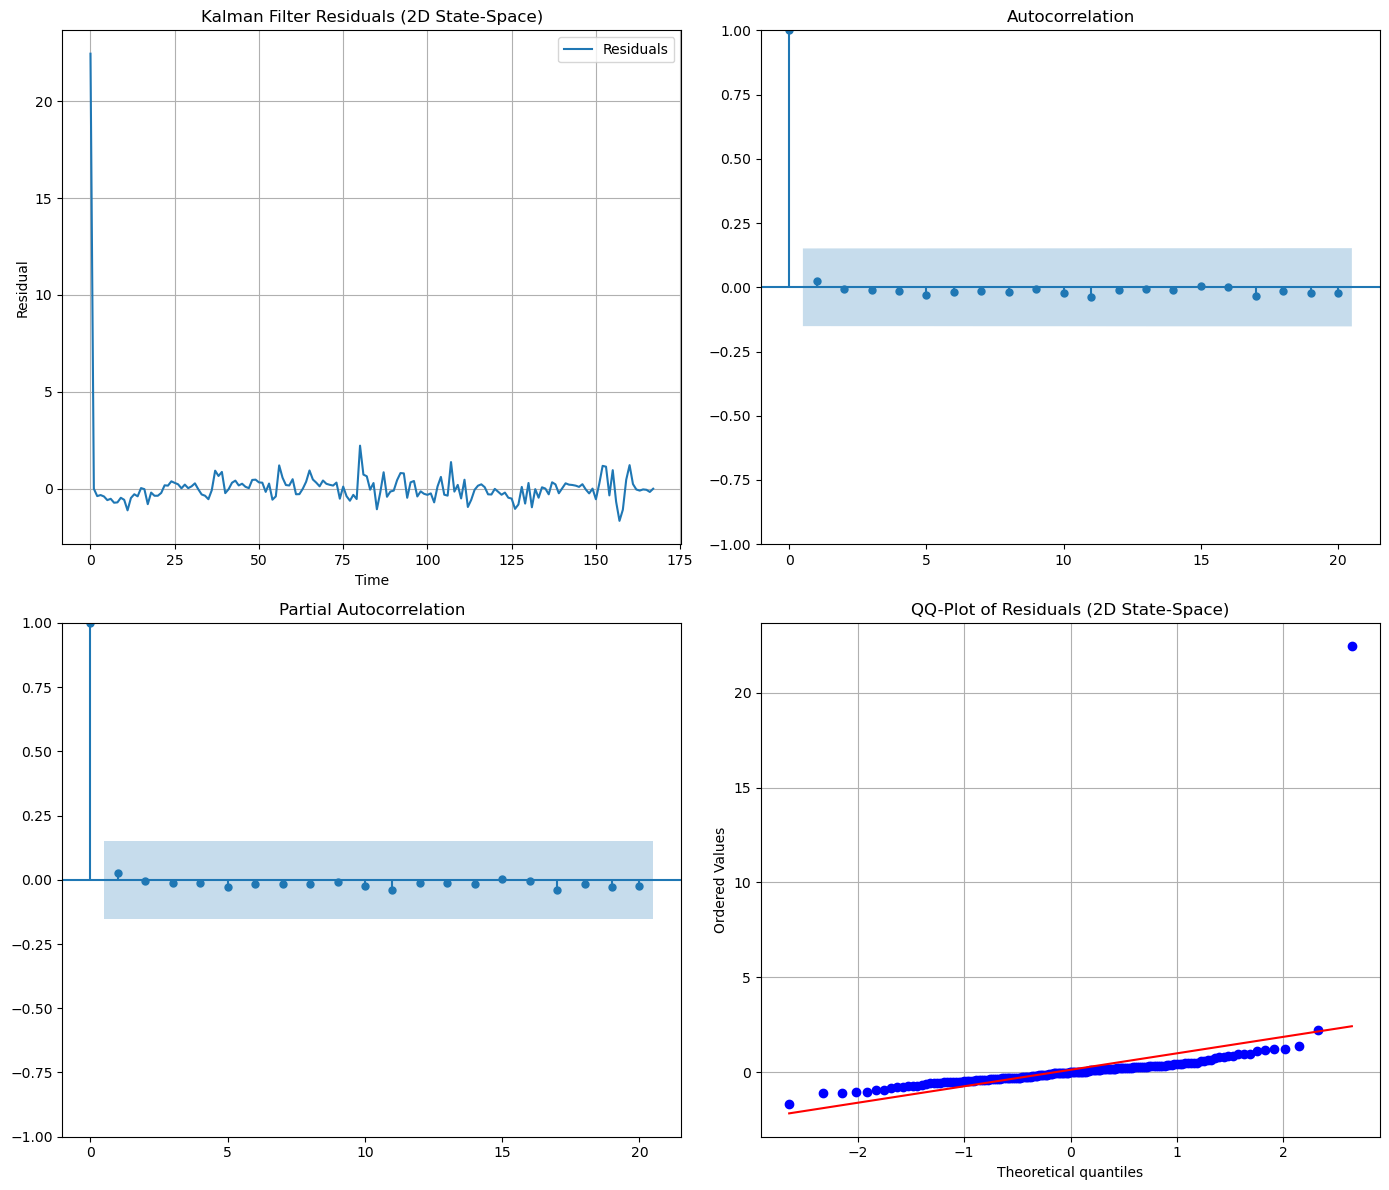

C:\Users\Zosia\AppData\Local\Temp\ipykernel_23636\3355750187.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(logLik)


(303.5517916809522, np.float64(347.2872873925978))

In [65]:
# Create a single figure with subplots for residuals, ACF, PACF, and QQ plot
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Residuals plot
axes[0, 0].plot(residuals_2d, label='Residuals')
axes[0, 0].set_title('Kalman Filter Residuals (2D State-Space)')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Residual')
axes[0, 0].grid()
axes[0, 0].legend()

# ACF plot
plot_acf(residuals_2d, ax=axes[0, 1], lags=20)
axes[0, 1].set_title('Autocorrelation')

# PACF plot
plot_pacf(residuals_2d, ax=axes[1, 0], lags=20)
axes[1, 0].set_title('Partial Autocorrelation')

# QQ plot
probplot(residuals_2d, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('QQ-Plot of Residuals (2D State-Space)')
axes[1, 1].grid()

plt.tight_layout()
plt.show()

# AIC and BIC
loglik_2d = kf_logLik_2d(best_par, Y, U)
k = len(best_par)
n = len(Y)
aic = -2 * loglik_2d + 2 * k
bic = -2 * loglik_2d + k * np.log(n)
aic, bic
